## 0. 대회 및 데이터셋 설명

https://www.kaggle.com/competitions/spaceship-titanic/overview

<이진분류 - bool값으로 제출>
- 2912년 우주선 타이타닉은 3개의 외계 행성(Destination)으로 승객들을 수송한다. 첫 번째 목적지 55 Cancri e로 가는 도중 시공간의 이상 현상과 충돌해서 **승객의 절반이 다른 차원으로 이동**했다.
- 이들을 구하기 위해 어떤 승객(PassengerId)이 다른 차원으로 이동했는지(Transported)를 예측해야 한다.
- 평가 기준: accuracy


컬럼 설명
- PassengerId: 고유 ID, gggg_pp 형식(gggg - 함께 여행하는 그룹, pp - 그룹 내의 번호)
- HomePlanet: 출발지(Earth, Europa, Mars)
- CryoSleep: 수면 선택 여부(T/F), True인 경우 객실(Cabin)에 갇혀 있음
- Cabin: 객실 번호, deck/num/side 형식
  - deck - A, B, C, D, E, F, G, T
  - side - P(좌), S(우)
- Destination: 목적지(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e)
- Age: 나이 (0~79)
- VIP: VIP 서비스 비용을 지불했는지 여부(T/F)
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: 고급 편의 시설에 지불한 금액
- Name: 이름
- Transported: 다른 차원으로 이동했는지 여부(T/F), 타겟 변수


## 1. EDA 및 시각화

### train, test - 분포 확인

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [ ]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
# test에도 결측치 존재 -> 결측치 처리할 때 train, test 합쳐서 한 번에 처리
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

### train, test - dtype 변경 및 컬럼 분리

- T/F인 CryoSleep, VIP, Transported -> float으로 변경
- Cabin: Deck/DeckNum/DeckSide로 분리 후 DeckNum 삭제
- Name 삭제

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# train, test 합쳐서 수정
df = pd.concat([train,test]).reset_index(drop = True)

In [5]:
# CryoSleep, VIP, Transported를 float로 변경
df['CryoSleep'] = df['CryoSleep'].replace({'True': 1, 'False': 0}).astype('float64')
df['VIP'] = df['VIP'].replace({'True': 1, 'False': 0}).astype('float64')
df['Transported'] = df['Transported'].astype('float64')

In [6]:
df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
12965,9266_02,Earth,1.0,G/1496/S,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,0.0,NaN,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,1.0,D/296/P,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,0.0,D/297/P,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN
12969,9277_01,Earth,1.0,G/1498/S,PSO J318.5-22,43.0,0.0,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN


In [ ]:
# Cabin 결측값을 같은 형식(//)으로 변경
df['Cabin'] = df['Cabin'].fillna('nan/nan/nan')

# Cabin을 '/' 기준 3개로 분리
cols = ['Deck', 'DeckNum', 'DeckSide']

for col in cols:
  df[col] = 1

for i in range(df.shape[0]):
  df['Deck'][i] = df['Cabin'][i].split('/')[0]
  df['DeckNum'][i] = df['Cabin'][i].split('/')[1]
  df['DeckSide'][i] = df['Cabin'][i].split('/')[2]

# 'nan'(문자열)을 nan(null값)으로 변경
df['Deck'] = df['Deck'].replace('nan', np.nan)
df['DeckNum'] = df['DeckNum'].replace('nan', np.nan)
df['DeckSide'] = df['DeckSide'].replace('nan', np.nan)

In [ ]:
# 불필요한 컬럼 제거
df.drop(columns = ['Name', 'DeckNum', 'Cabin'], inplace=True)

In [ ]:
# 그저 미관상으로 예쁘게 ㅎㅎ Transported가 맨 뒤에 오게 변경
Transported_column = df.pop('Transported')
df['Transported'] = Transported_column

In [ ]:
df.head(1)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,DeckSide,Transported
0,0001_01,Europa,0,TRAPPIST-1e,39,0,0.0,0.0,0.0,0.0,0.0,B,P,0


In [ ]:
# 범주형 컬럼 고유값 및 이상값 확인 -> 이상값 없음
for column in df.select_dtypes(include=['object']).columns:
  unique_values = df[column].unique()
  print(f"{column}: {unique_values}")

PassengerId: ['0001_01' '0002_01' '0003_01' ... '9271_01' '9273_01' '9277_01']
HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Deck: ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
DeckSide: ['P' 'S' nan]


In [ ]:
# train과 test로 다시 분리
train = df[~df['Transported'].isnull()].reset_index(drop = True)
test = df[df['Transported'].isnull()].reset_index(drop=True)

# test에 Transported 컬럼 삭제
test.drop(columns = 'Transported', inplace=True)

### train - 컬럼 분포 확인 및 시각화

In [ ]:
train.head(1)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,DeckSide,Transported
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,P,0.0


In [ ]:
# RoomService~VRDeck: 0값이 절반 이상
train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


num형 분포 확인
- Age 이상치 확인 - 소숫점 있는 데이터 없음

In [8]:
train['Age'].unique()

array([39., 24., 58., 33., 16., 44., 26., 28., 35., 14., 34., 45., 32.,
       48., 31., 27.,  0.,  1., 49., 29., 10.,  7., 21., 62., 15., 43.,
       47.,  2., 20., 23., 30., 17., 55.,  4., 19., 56., nan, 25., 38.,
       36., 22., 18., 42., 37., 13.,  8., 40.,  3., 54.,  9.,  6., 64.,
       67., 61., 50., 41., 57., 11., 52., 51., 46., 60., 63., 59.,  5.,
       79., 68., 74., 12., 53., 65., 71., 75., 70., 76., 78., 73., 66.,
       69., 72., 77.])

In [ ]:
# 0살이 178명이나 있으니까 만 나이겠죠...?
train[train['Age'] == 0].shape[0]

178

- RoomService~VRDeck: 왜도가 높아 모델링 전에 log 변환 등이 필요해 보임
- 아니면 결측치 처리 후 5개를 더해서 총 지출비용 컬럼을 만드는 것은 어떨지
- 결측치 처리 전 극이상치를 평균값으로 대체할지 or 그냥 놔둘지 선택이 필요해 보임

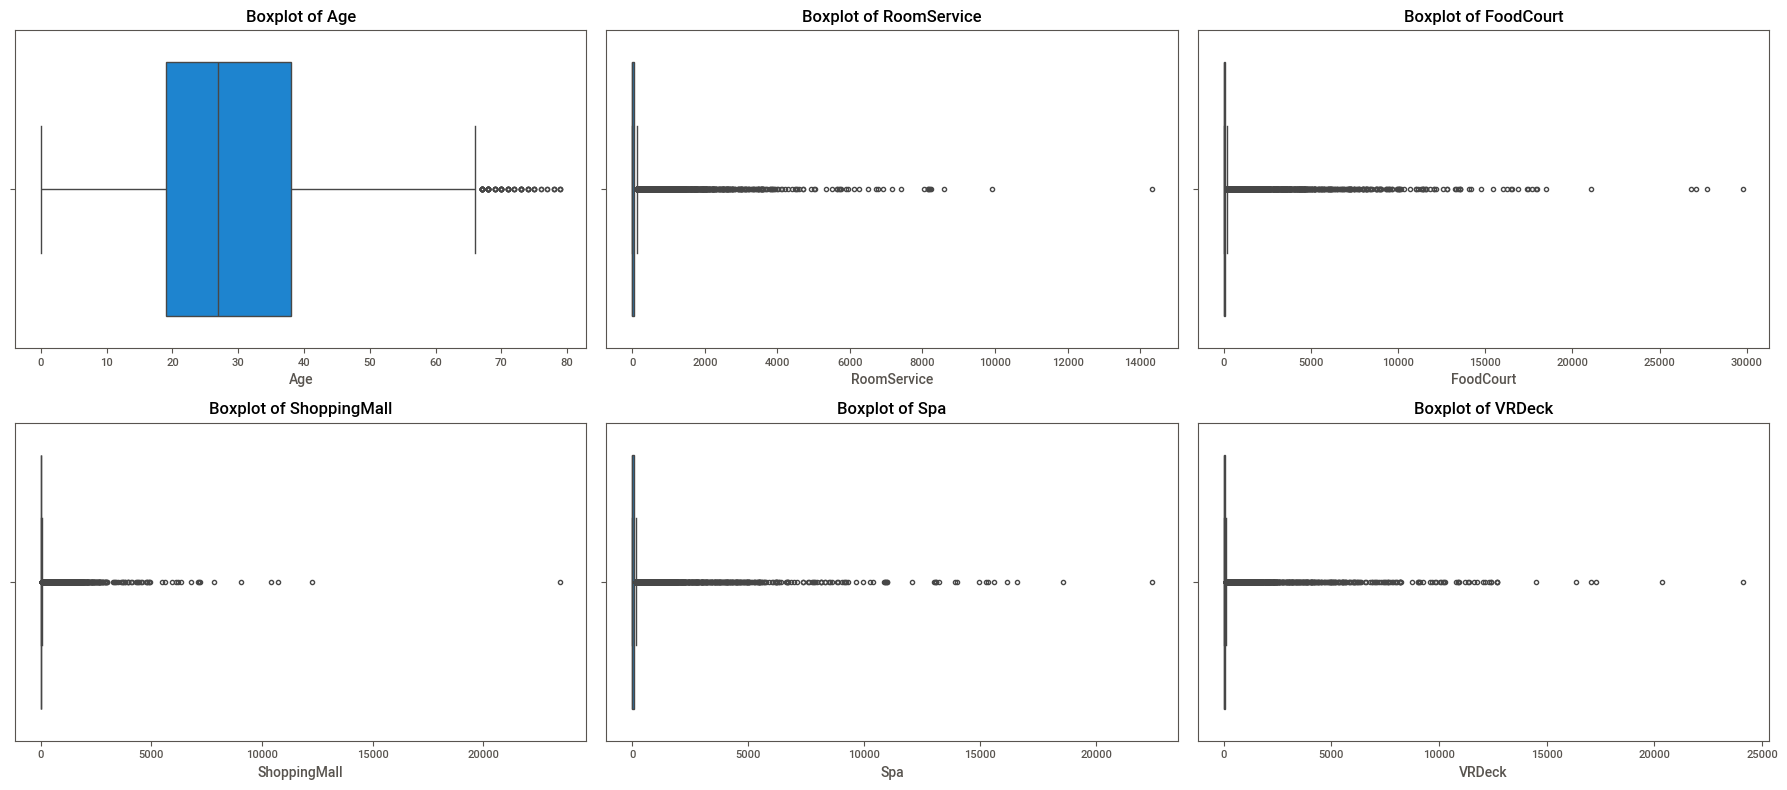

In [ ]:
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

for i, col in enumerate(num_cols):
    sns.boxplot(x=train[col], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Boxplot of {col}')

plt.tight_layout()

bool형 분포 확인

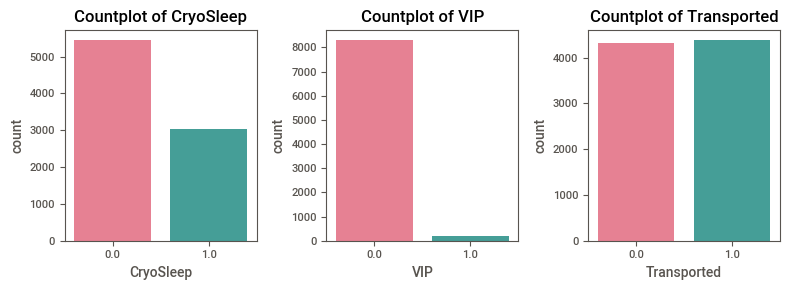

In [ ]:
bool_cols = ['CryoSleep', 'VIP', 'Transported']

fig, axes = plt.subplots(nrows=1, ncols=len(bool_cols), figsize=(8, 3))

for i, col in enumerate(bool_cols):
    sns.countplot(x=col, data=train, ax=axes[i], hue=col, legend=False, palette='husl')
    axes[i].set_title(f'Countplot of {col}')

plt.tight_layout()

sweetviz (html 파일이랑 같이 봐주세요)

In [ ]:
pip install sweetviz

In [ ]:
import sweetviz as sv

my_report = sv.analyze(train, feat_cfg = sv.FeatureConfig(skip=['PassengerId']), target_feat='Transported')
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


- HomePlanet & Deck 상관계수 0.56 -> 다중공선성 유발
- CryoSleep=1의 Transported 82%
- Age<10(전체의 8%)의 Transported 71%
- Deck=B(전체의 9%)의 Transported 73%


HomePlanet & Deck 상관계수 0.56인 이유?
- 8개 중 5개의 Deck이 하나의 HomePlanet으로 이루어져 있음
- 특히 승객 수가 전체의 30%인 G 객실 승객들의 HomePlanet이 모두 Earth
- 모든 승객이 Europa인 A, B, C, T 중 B의 Transported가 73%, C는 68%, A는 50%
  - Europa의 Transported(61%)가 평균(50%)보다 높다는 것을 시사함 (수치는 sweetviz에서 찾음)

Text(0.5, 1.0, 'Countplot of HomePlanet')

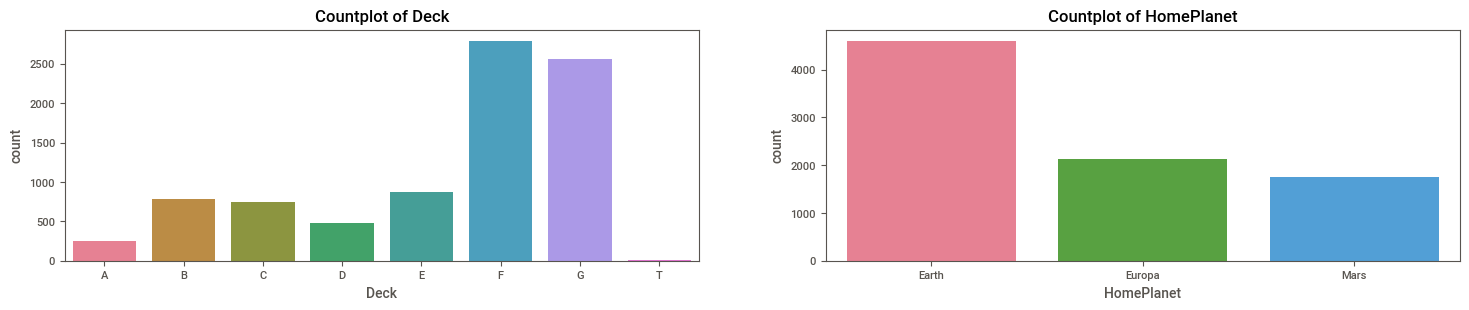

In [ ]:
# Deck, HomePlanet CountPlot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
sns.countplot(x='Deck', data=train.sort_values(by='Deck'), hue='Deck', legend=False, palette='husl', ax=axes[0])
axes[0].set_title('Countplot of Deck')
sns.countplot(x='HomePlanet', data=train.sort_values(by='HomePlanet'), hue='HomePlanet', legend=False, palette='husl', ax=axes[1])
axes[1].set_title('Countplot of HomePlanet')

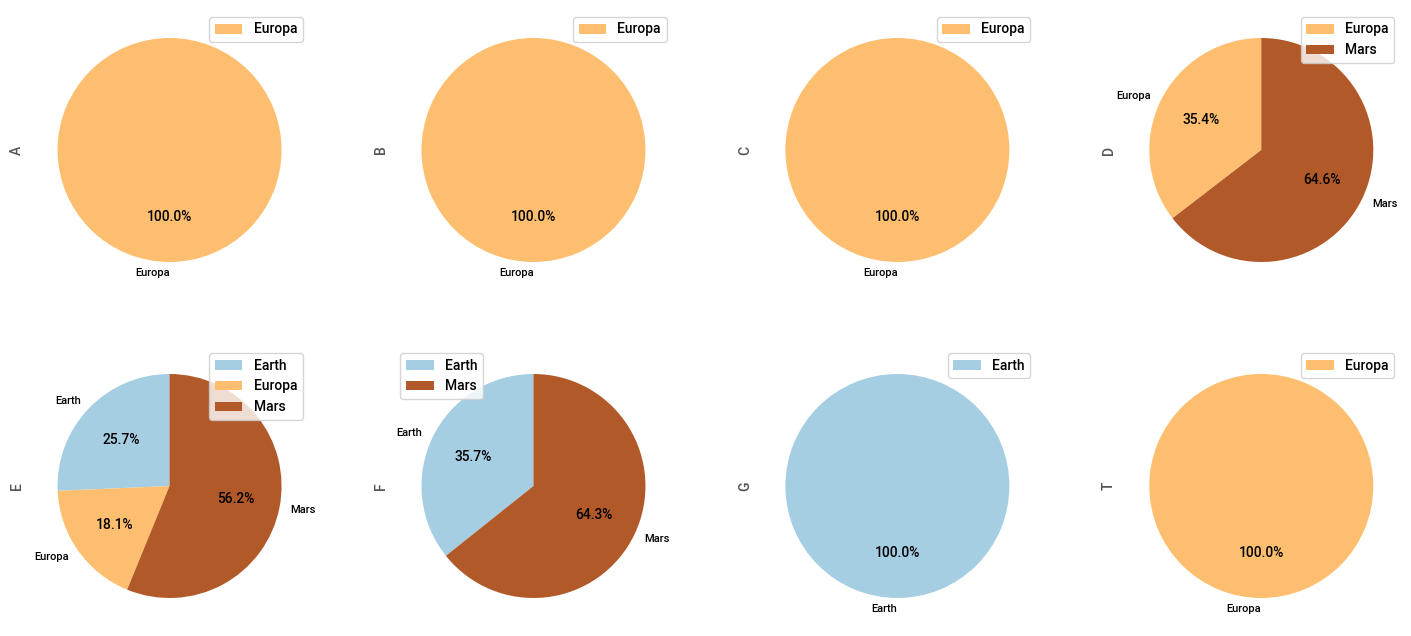

In [ ]:
# Deck별 HomePlanet 비율
deck_homeplanet_ratio = train.groupby('HomePlanet')['Deck'].value_counts(normalize=True).unstack(fill_value=0)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
deck_homeplanet_ratio.plot(kind='pie', ax=axes, autopct=lambda p: f'{p:.1f}%' if p > 0 else '', startangle=90, cmap='Paired', subplots=True)
plt.legend(loc='upper right')

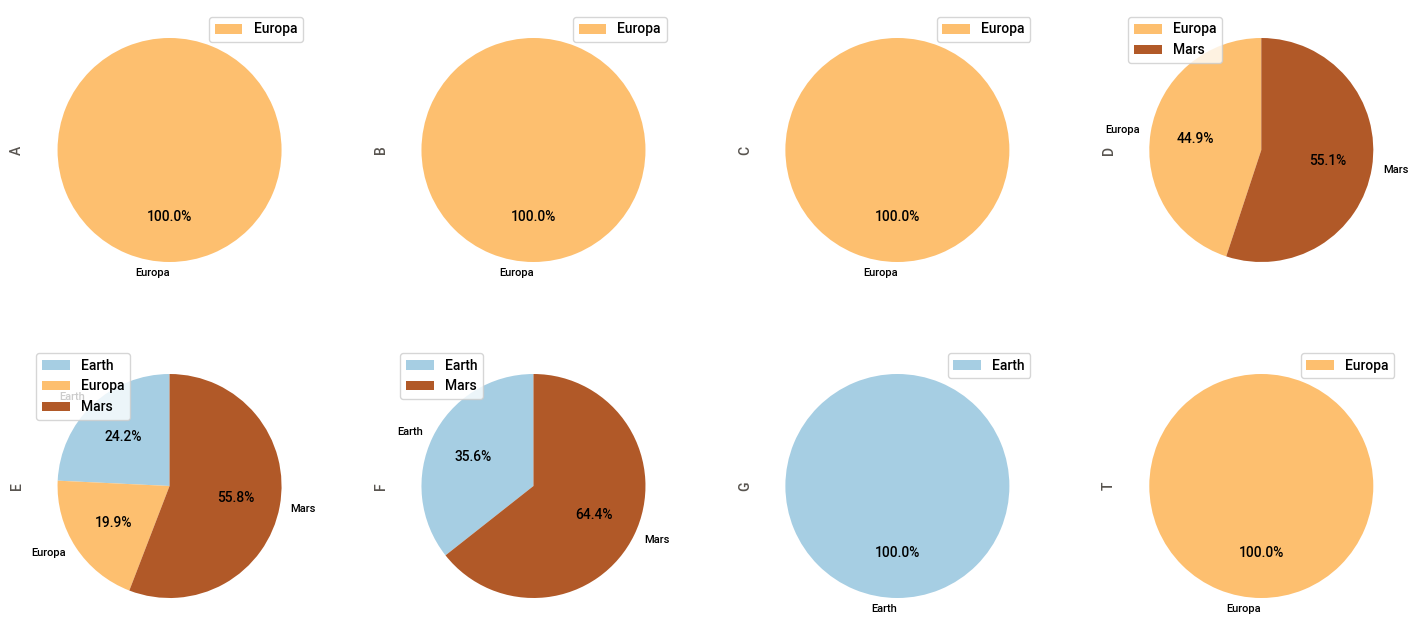

In [ ]:
# 혹시 몰라서 test 데이터프레임도 해봄
deck_homeplanet_ratio = test.groupby('HomePlanet')['Deck'].value_counts(normalize=True).unstack(fill_value=0)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
deck_homeplanet_ratio.plot(kind='pie', ax=axes, autopct=lambda p: f'{p:.1f}%' if p > 0 else '', startangle=90, cmap='Paired', subplots=True)
plt.legend(loc='upper right')

데이터셋 설명 중 'CryoSleep=1은 Cabin에 갇혀 있다' -> CryoSleep=1의 특징 분석

In [ ]:
# VIP 비율이 0.7%
# RoomService~VRDeck: 전부 다 0
train[train['CryoSleep']==1].describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,3037.0,2955.000000,2962.000000,2969.0,2967.0,2941.0,2972.0,2975.0,3037.000000
mean,1.0,27.405415,0.007090,0.0,0.0,0.0,0.0,0.0,0.817583
std,0.0,15.080469,0.083916,0.0,0.0,0.0,0.0,0.0,0.386251
min,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
25%,1.0,18.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
50%,1.0,26.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
75%,1.0,37.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
max,1.0,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000


In [ ]:
# 혹시 몰라서 test 데이터프레임도 해봄
test[test['CryoSleep']==1].describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,1544.0,1512.000000,1515.000000,1519.0,1505.0,1509.0,1502.0,1515.0
mean,1.0,27.716931,0.004620,0.0,0.0,0.0,0.0,0.0
std,0.0,14.506779,0.067839,0.0,0.0,0.0,0.0,0.0
min,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,1.0,18.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,1.0,26.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,1.0,37.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,1.0,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Countplot of HomePlanet')

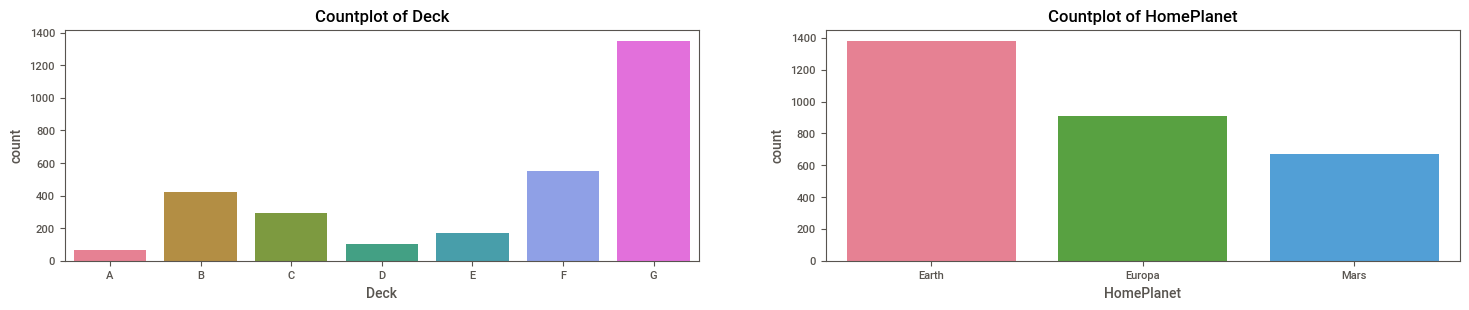

In [ ]:
# Deck, HomePlanet 분포는 원본과 비슷함
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
sns.countplot(x='Deck', data=train[train['CryoSleep']==1].sort_values(by='Deck'), hue='Deck', legend=False, palette='husl', ax=axes[0])
axes[0].set_title('Countplot of Deck')
sns.countplot(x='HomePlanet', data=train[train['CryoSleep']==1].sort_values(by='HomePlanet'), hue='HomePlanet', legend=False, palette='husl', ax=axes[1])
axes[1].set_title('Countplot of HomePlanet')

### EDA 및 시각화 요약

0. 결측치 처리 이전
  - RoomService~VRDeck 극이상치를 평균값으로 대체할지 or 그냥 놔둘지
    - 10개 정도밖에 안 돼서 그냥 놔두기로 함

1. 결측치 처리
  - 일반적으로 이렇게 하지만
    - 범주형 데이터 - 최빈값
    - 수치형 데이터 - 평균 or 중앙값
  - 이런 거 더 발견하면 모델 성능이 향상될 겁니다 (test에도 결측치 있으니 train이랑 test 합쳐서 찾아보는 거 추천)
    - CyroSleep=1이면 -> RoomService~VRDeck은 모두 0
    - Deck이 A, B, C, T이면 -> HomePlanet은 Europa
    - Deck이 G이면 -> HomePlanet은 Earth

2. 파생변수 의견!
  - 결측치 처리 후 RoomService~VRDeck 5개를 더해서 총 지출비용 컬럼을 만드는 것은 어떨지
  - 왜냐면 어차피 CyroSleep=1인 사람들은 5개가 다 0이니까, 각각의 비용이 분석에 큰 영향을 주지 않을 것 같음

3. 가장 유의미한 변수는 CyroSleep - 1인 사람의 82%가 Transported

4. RoomService~VRDeck는 왜도가 높아 모델링 전에 log 변환 등이 필요해 보임

In [ ]:
train.to_csv('train_1.csv', index=False)
test.to_csv('test_1.csv', index=False)

## 2. 결측치 처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
train = pd.read_csv('./train_1.csv')
test = pd.read_csv('./test_1.csv')

In [ ]:
# train, test 한 번에 수정
df = pd.concat([train,test]).reset_index(drop = True)

### 결측치 시각화

<Axes: >

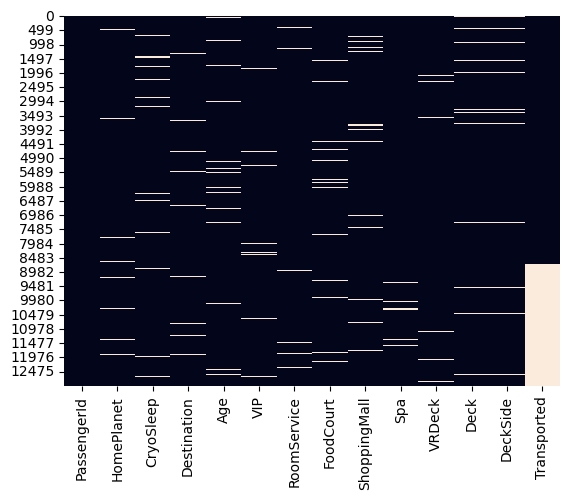

In [ ]:
sns.heatmap(df.isnull(),cbar=False)

- Tansported의 후반부 결측치는 test 데이터셋으로 인한 것임
- Deck과 DeckSide는 동일한 패턴을 보이고 있음
- Homeplanet과 Destination 또한 일부 동일함

### 칼럼별 상관관계 확인

In [ ]:
print("CryoSleep과 HomePlanet")
cryosleep_homeplanet = df.groupby('HomePlanet')['CryoSleep'].mean()
print(cryosleep_homeplanet)

print("\nCryoSleep과 Age")
cryosleep_age = df.groupby('CryoSleep')['Age'].mean()
print(cryosleep_age)

print("\nCryosleep과 Roomservice, FoodCourt, ShoppingMall, Spa, VRDeck")
cryosleep_service = df.groupby('CryoSleep')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()
print(cryosleep_service)

print("\nCryosleep과 VIP")
cryosleep_vip = df.groupby('VIP')['CryoSleep'].mean()
print(cryosleep_vip)

CryoSleep과 HomePlanet
HomePlanet
Earth     0.308863
Europa    0.450197
Mars      0.394205
Name: CryoSleep, dtype: float64

CryoSleep과 Age
CryoSleep
0.0    29.484229
1.0    27.510857
Name: Age, dtype: float64

Cryosleep과 Roomservice, FoodCourt, ShoppingMall, Spa, VRDeck
           RoomService   FoodCourt  ShoppingMall         Spa      VRDeck
CryoSleep                                                               
0.0         349.153185  709.269046    274.165782  482.310532  481.595196
1.0           0.000000    0.000000      0.000000    0.000000    0.000000

Cryosleep과 VIP
VIP
0.0    0.367504
1.0    0.104869
Name: CryoSleep, dtype: float64


- CyroSleep=1이면 -> RoomService~VRDeck은 모두 0

In [ ]:
print("Destination과 CryoSleep")
destination_cryosleep = df.groupby('Destination')['CryoSleep'].mean()
print(destination_cryosleep)

print("\nDestination과 HomePlanet")
destination_homeplanet = df.groupby('HomePlanet')['Destination'].value_counts(normalize=True).unstack()
print(destination_homeplanet)

print("\nDestination과 Age")
destination_age = df.groupby('Destination')['Age'].mean()
print(destination_age)

print("\nDestination과 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck")
destination_service = df.groupby('Destination')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()
print(destination_service)

print("\nDestination과 VIP")
destination_vip = df.groupby('Destination')['VIP'].mean()
print(destination_vip)

Destination과 CryoSleep
Destination
55 Cancri e      0.427851
PSO J318.5-22    0.496546
TRAPPIST-1e      0.326094
Name: CryoSleep, dtype: float64

Destination과 HomePlanet
Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet                                          
Earth           0.146407       0.158459     0.695135
Europa          0.425878       0.009428     0.564694
Mars            0.112342       0.025602     0.862056

Destination과 Age
Destination
55 Cancri e      29.385328
PSO J318.5-22    27.350000
TRAPPIST-1e      28.766697
Name: Age, dtype: float64

Destination과 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
               RoomService   FoodCourt  ShoppingMall         Spa      VRDeck
Destination                                                                 
55 Cancri e     192.520664  864.188949    156.498832  505.479239  513.400541
PSO J318.5-22    97.216076  138.404163    119.303371  117.934483  144.872103
TRAPPIST-1e     249.495340  374.574954    188.003805  27

- Destination과 HomePlanet 칼럼이 유의미한 관계를 가지는 것으로 보임 -> 각 범주의 최빈값으로 결측값 채우기  
- Destination이 55 Cancri e인 경우 FoodCourt, Spa, VRDeck에 지불한 비용이 큼. 특히 FoodCourt에 큰 비용을 지불하는 경향이 있음
- Destination이 PSO J318.5-22인 경우 전반적으로 서비스 비용 지불이 작음

In [ ]:
print("\nVIP와 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck\n")
destination_service = df.groupby('VIP')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()
print(destination_service)


VIP와 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   216.735698   419.522808    174.006608  292.849402   285.578406
1.0   486.349442  1793.651685    273.680451  932.847584  1207.199248


- VIP인 경우 FoodCourt, Spa, VRDeck의 지불 비용이 매우 큼

In [ ]:
print("Deck과 CryoSleep")
deck_cryosleep = df.groupby('Deck')['CryoSleep'].mean()
print(deck_cryosleep)

print("\nDeck과 HomePlanet")
deck_homeplanet = df.groupby('Deck')['HomePlanet'].value_counts(normalize=True).unstack()
print(deck_homeplanet)

print("\nDeck과 Age")
deck_age = df.groupby('Deck')['Age'].mean()
print(deck_age)

print("\nDeck과 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck")
deck_service = df.groupby('Deck')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()
print(deck_service)

print("\nDeck과 VIP")
deck_vip = df.groupby('Deck')['VIP'].mean()
print(deck_vip)

Deck과 CryoSleep
Deck
A    0.296512
B    0.544883
C    0.430568
D    0.239038
E    0.195046
F    0.205847
G    0.546587
T    0.000000
Name: CryoSleep, dtype: float64

Deck과 HomePlanet
HomePlanet     Earth    Europa      Mars
Deck                                    
A                NaN  1.000000       NaN
B                NaN  1.000000       NaN
C                NaN  1.000000       NaN
D                NaN  0.421652  0.578348
E           0.452640  0.152950  0.394410
F           0.586132       NaN  0.413868
G           1.000000       NaN       NaN
T                NaN  1.000000       NaN

Deck과 Age
Deck
A    35.479651
B    33.444942
C    34.639147
D    33.513475
E    30.285494
F    28.366282
G    24.010549
T    35.545455
Name: Age, dtype: float64

Deck과 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
      RoomService    FoodCourt  ShoppingMall          Spa       VRDeck
Deck                                                                  
A      121.723343  1440.565341     98.153623  

- Deck이 A, B, C, T이면 -> HomePlanet은 Europa
- Deck이 G이면 -> HomePlanet은 Earth

Deck          A     B     C    D    E     F     G   T
HomePlanet                                           
Earth         0     0     0    0  583  2426  3700   0
Europa      346  1124  1081  296  197     0     0  10
Mars          0     0     0  406  508  1713     0   0


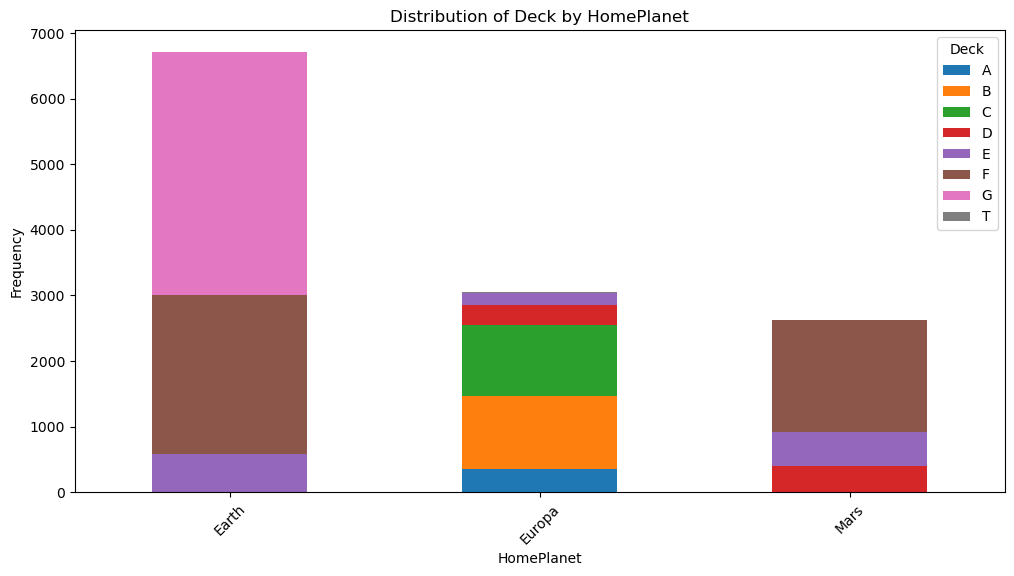

In [ ]:
# HomePlanet에 따른 Deck 빈도 계산
homeplanet_deck_freq = df.groupby('HomePlanet')['Deck'].value_counts().unstack(fill_value=0)
print(homeplanet_deck_freq)

# 시각화
homeplanet_deck_freq.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Deck by HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Deck')
plt.show()

- Homeplanet이 Earth -> deck을 F 또는 G로  
- Homplanet이 Europa -> deck을 B 또는 C로
- Homplanet이 Mars -> deck을 F로

In [ ]:
# deck과 deckside
deck_deckside = pd.crosstab(df['Deck'], df['DeckSide'])
print(deck_deckside)

DeckSide     P     S
Deck                
A          166   188
B          512   629
C          533   569
D          370   350
E          641   682
F         2178  2061
G         1885  1896
T            5     6


### 결측치 대체

1. Cyrosleep 칼럼의 결측치 대체

In [ ]:
for index, row in df.iterrows(): # 서비스 지불 비용이 모두 0이면 True
    if pd.isnull(row['CryoSleep']):
        if row[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].all() == 0:
            df.at[index, 'CryoSleep'] = 1

2. Homplanet과 Destination 칼럼 결측치 대체

In [ ]:
# HomePlanet과 Destination의 교차표 생성
cross_tab = pd.crosstab(df['HomePlanet'], df['Destination'], normalize='index')

# HomePlanet의 결측치 imputation
def impute_HomePlanet(row):
    if pd.isnull(row['HomePlanet']):
        if row['Deck'] in ['A', 'B', 'C', 'T']:
            row['HomePlanet'] = 'Europa'
        elif row['Deck'] == 'G':
            row['HomePlanet'] = 'Earth'

    # Destination별 HomePlanet의 최빈값으로 대체
    if pd.isnull(row['HomePlanet']) and pd.notnull(row['Destination']):
        return cross_tab.loc[:, row['Destination']].idxmax()
    else:
        return row['HomePlanet']

# HomePlanet별 Destination의 최빈값으로 대체
def impute_Destination(row):
    if pd.isnull(row['Destination']) and pd.notnull(row['HomePlanet']):
        return cross_tab.loc[row['HomePlanet'], :].idxmax()
    else:
        return row['Destination']

# imputaion 적용
df['HomePlanet'] = df.apply(impute_HomePlanet, axis=1)
df['Destination'] = df.apply(impute_Destination, axis=1)

3. 서비스(RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) 칼럼 결측치 대체

In [ ]:
# Destination별 서비스 사용 평균 계산
service_means = df.groupby('Destination')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean().apply(np.floor)

# VIP와 Destination에 따라 결측치 대체
def impute_services(row):
    if pd.notnull(row['Destination']):
        for service in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
            if pd.isnull(row[service]):
                mean_value = service_means.loc[row['Destination'], service]
                if row['VIP'] == 1 and service in ['FoodCourt', 'Spa', 'VRDeck']:
                    row[service] = np.floor(mean_value * 1.5)  # VIP 승객의 경우 서비스 비용을 평균보다 높게 설정하고 소수점 버림
                else:
                    row[service] = mean_value
    return row

# imputation 적용
df = df.apply(impute_services, axis=1)

4. Deck 칼럼의 결측치 대체

In [ ]:
def impute_Deck(deck, homeplanet):
    if pd.isnull(deck):
        if homeplanet == 'Earth':
            return 'F' if np.random.rand() < 0.5 else 'G'
        elif homeplanet == 'Europa':
            return 'B' if np.random.rand() < 0.5 else 'C'
        elif homeplanet == 'Mars':
            return 'F'
    else:
        return deck

# 각 행에 대해 결측치 처리 및 대체 적용
for index, row in df.iterrows():
    homeplanet = 'Earth' if index in ['A', 'B', 'C', 'G', 'T'] else 'Europa' if index == 'D' else 'Mars'
    df.at[index, 'Deck'] = impute_Deck(row['Deck'], homeplanet)

5. DeckSide 칼럼의 결측치 대체

In [ ]:
for index, row in df.iterrows():
    if pd.isna(row['DeckSide']):
        # 해당 Deck의 주변 정보 수집
        nearby_deck = df[df['Deck'] == row['Deck']]
        # 주변 정보를 기반으로 결측치 대체
        if 'P' in nearby_deck['DeckSide'].values:
            df.at[index, 'DeckSide'] = 'S'
        elif 'S' in nearby_deck['DeckSide'].values:
            df.at[index, 'DeckSide'] = 'P'

6. 나머지 결측치 대체

In [ ]:
df.isnull().sum()

PassengerId        0
HomePlanet         2
CryoSleep         17
Destination        2
Age              270
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Deck               0
DeckSide           0
Transported     4277
dtype: int64

In [ ]:
# 범주형 -> 최빈값으로 대체
# 수치형 -> 중간값으로 대체
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['CryoSleep'] = df['CryoSleep'].fillna(0) # 최빈값 0
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
df['Age'] = df['Age'].fillna(df['Age'].median())
df['VIP'] = df['VIP'].fillna(0) # 최빈값 0

In [ ]:
df.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Deck               0
DeckSide           0
Transported     4277
dtype: int64

In [ ]:
# train과 test로 다시 분리
train = df[~df['Transported'].isnull()].reset_index(drop = True)
test = df[df['Transported'].isnull()].reset_index(drop=True)

# csv로 내보내기
train.to_csv('train_2.csv', index=False)
test.to_csv('test_2.csv', index=False)

## 3. 데이터 엔지니어링

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('./train_2.csv')
test = pd.read_csv('./test_2.csv')

In [ ]:
# train, test 한 번에 수정
df = pd.concat([train,test]).reset_index(drop = True)

### 범주형 컬럼 원핫인코딩

- CryoSleep, VIP, HomePlanet, Destination, Deck, DeckSide 원핫인코딩

In [ ]:
df = pd.get_dummies(df, columns=['CryoSleep','VIP','HomePlanet','Destination','Deck','DeckSide'], dtype=float)

### 수치형 컬럼 정규화

- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Age

In [ ]:
# 서비스 비용 로그 변환 (0이 포함되므로 1을 더한 후 로그 변환)
df['RoomService'] = np.log1p(df['RoomService'])
df['FoodCourt'] = np.log1p(df['FoodCourt'])
df['ShoppingMall'] = np.log1p(df['ShoppingMall'])
df['Spa'] = np.log1p(df['Spa'])
df['VRDeck'] = np.log1p(df['VRDeck'])

In [ ]:
# MinMax Scaling
from sklearn.preprocessing import MinMaxScaler

normalize = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
scaler = MinMaxScaler()
df[normalize] = scaler.fit_transform(df[normalize])

### 총 지출비용(서비스 비용의 합) 컬럼 생성

In [ ]:
# 총 지출비용 컬럼 생성
df['TotalSpending'] = (df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'])/5

# 불필요한 칼럼 삭제
df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

In [ ]:
df.head()

,PassengerId,Age,Transported,CryoSleep_0.0,CryoSleep_1.0,VIP_0.0,VIP_1.0,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,DeckSide_P,DeckSide_S,TotalSpending
0,0001_01,0.493671,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,0002_01,0.303797,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.409102
2,0003_01,0.734177,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.491396
3,0003_02,0.417722,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.522907
4,0004_01,0.202532,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.450388


### Transported 컬럼 bool형 변환 (submission을 bool형으로 해야 함)

In [ ]:
# train과 test로 다시 분리
train = df[~df['Transported'].isnull()].reset_index(drop=True)
test = df[df['Transported'].isnull()].reset_index(drop=True)

# 분석 마친 후, train 데이터의 Transported 값을 bool형으로 되돌리기
train['Transported'] = train['Transported'].astype(bool)

In [ ]:
train.isnull().sum()

PassengerId                  0
Age                          0
Transported                  0
CryoSleep_0.0                0
CryoSleep_1.0                0
VIP_0.0                      0
VIP_1.0                      0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
DeckSide_P                   0
DeckSide_S                   0
TotalSpending                0
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId                     0
Age                             0
Transported                  4277
CryoSleep_0.0                   0
CryoSleep_1.0                   0
VIP_0.0                         0
VIP_1.0                         0
HomePlanet_Earth                0
HomePlanet_Europa               0
HomePlanet_Mars                 0
Destination_55 Cancri e         0
Destination_PSO J318.5-22       0
Destination_TRAPPIST-1e         0
Deck_A                          0
Deck_B                          0
Deck_C                          0
Deck_D                          0
Deck_E                          0
Deck_F                          0
Deck_G                          0
Deck_T                          0
DeckSide_P                      0
DeckSide_S                      0
TotalSpending                   0
dtype: int64

In [ ]:
# CSV 파일로 저장
train.to_csv('train_3.csv', index=False)
test.to_csv('test_3.csv', index=False)

## 4. 모델링 및 성능 평가

- XGBoost로 예측 진행
- GridSerchCV, HyperOpt로 하이퍼 파라미터 튜닝 진행

### XGBoost(GridSearchCV) - 모델 예측

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train = pd.read_csv('/content/train_3.csv')
real_test = pd.read_csv('/content/test_3.csv')

In [ ]:
X = train.drop(columns=['Transported', 'PassengerId'])
y = train['Transported']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost 하이퍼 파라미터 default값으로 예측 - Accuracy 0.717

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')
xgb_model.fit(X_train, y_train)
y_pred_basic = xgb_model.predict(X_test)
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print(f"Test Accuracy before tuning: {accuracy_basic}")

Test Accuracy before tuning: 0.7165037377803335


하이퍼 파라미터 튜닝 진행

In [ ]:
param_grid = {
    'eta': [0.01, 0.03, 0.1, 0.2],  # 학습률: 모델이 학습하는 속도, 값이 낮을수록 천천히 학습함
    'max_depth': [3, 4, 5, 6, 7],  # 트리의 최대 깊이: 깊이가 깊을수록 모델이 더 복잡해짐 (오버피팅 조심!)
    'min_child_weight': [1, 3, 5, 7, 10],  # 최소 자식 노드 가중치 합: 값이 클수록 모델이 보수적임
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 각 트리 학습에 사용할 샘플 비율: 과적합 방지를 위해 사용
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # 각 트리 학습에 사용할 피처 비율: 과적합 방지를 위해 사용
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # 노드 분할의 최소 손실 감소: 값을 높이면 모델이 보수적임
}


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 3 folds for each of 12500 candidates, totalling 37500 fits
Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.03, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9}
Best Score: 0.7516537244751222


GridSerchCV로 도출한 최적의 파라미터로 예측 진행 - Accuracy 0.747

In [ ]:
best_params = {
    'colsample_bytree': 0.8,
    'eta': 0.03,
    'gamma': 0.1,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.9
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error', **best_params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7469810235767682


### XGBoost(GridSearchCV) - 모델 성능 평가

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

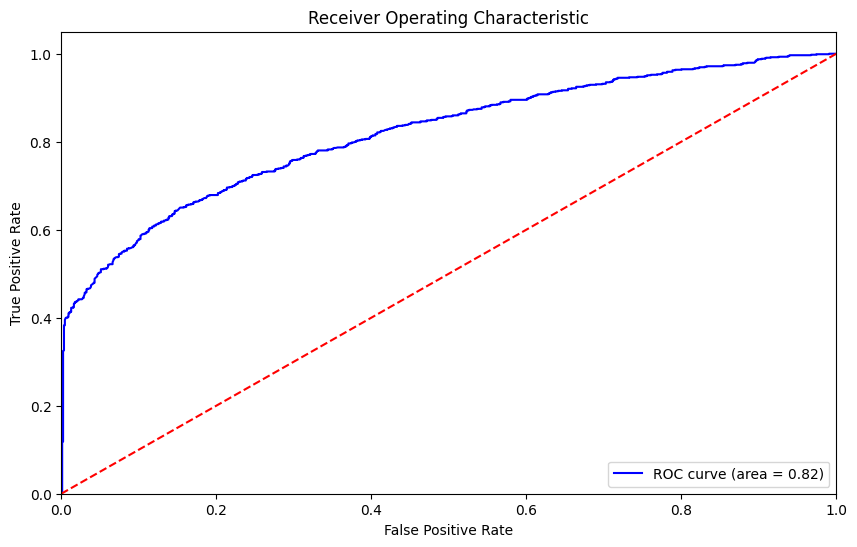

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Display metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC-AUC': roc_auc
}
print(metrics)

{'Accuracy': 0.7452558941920644, 'Precision': 0.8050490883590463, 'Recall': 0.6537585421412301, 'F1 Score': 0.7215587680703961, 'ROC-AUC': 0.8178860465793073}


### XGBoost(HyperOpt) - 모델 예측

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드 및 전처리
train_df = pd.read_csv('/content/train_3_2.csv')
train_df.drop(columns=['PassengerId'], inplace=True)

X_train = train_df.drop(columns=['Transported'])
y_train = train_df['Transported']

In [ ]:
# Objective 함수
def objective_func(params):
    xgb_clf = XGBClassifier(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            min_child_weight=int(params['min_child_weight']),
                            learning_rate=params['learning_rate'],
                            colsample_bytree=params['colsample_bytree'],
                            n_jobs=-1)

    accuracy_scores = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    mean_accuracy = accuracy_scores.mean()

    return {'loss': -1 * mean_accuracy, 'status': STATUS_OK}

In [ ]:
# Hyperparameter 탐색 범위 설정
xgb_search_space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
                    'max_depth': hp.quniform('max_depth', 1, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

# Hyperparameter 최적화 진랭
trials = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print('best:', best)

100%|██████████| 50/50 [02:19<00:00,  2.80s/trial, best loss: -0.7467672447232724]
best: {'colsample_bytree': 0.544607806957896, 'learning_rate': 0.1240587675598413, 'max_depth': 4.0, 'min_child_weight': 2.0, 'n_estimators': 200.0}


### XGBoost(HyperOpt) - 모델 성능 평가

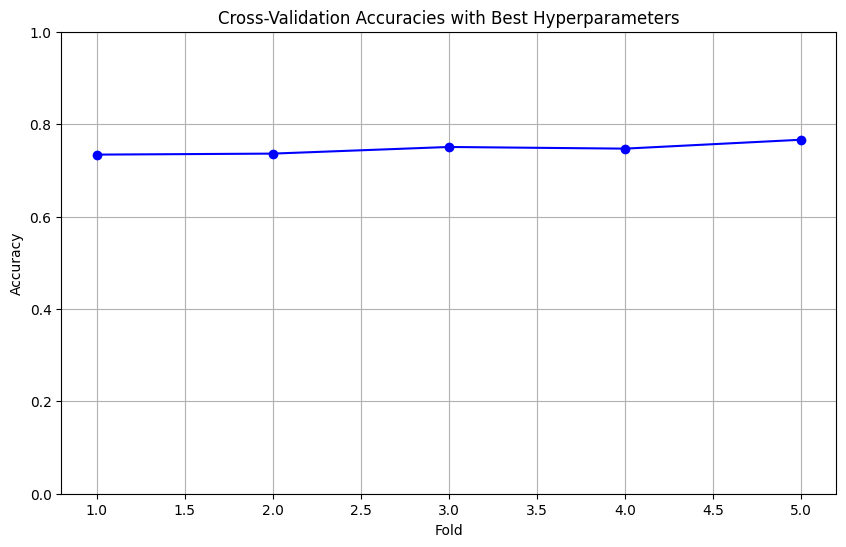

Fold Accuracies:  [0.73400431 0.73616104 0.75053918 0.74694464 0.76618705]
Mean Accuracy:  0.7467672447232724


In [ ]:
# 최적의 하이퍼파라미터로 모델 학습 및 교차 검증
best_xgb_clf = XGBClassifier(n_estimators=int(best['n_estimators']),
                             max_depth=int(best['max_depth']),
                             min_child_weight=int(best['min_child_weight']),
                             learning_rate=best['learning_rate'],
                             colsample_bytree=best['colsample_bytree'],
                             n_jobs=-1)

accuracy_scores = cross_val_score(best_xgb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
mean_accuracy = accuracy_scores.mean()

# 교차 검증 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracies with Best Hyperparameters')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("Fold Accuracies: ", accuracy_scores)
print("Mean Accuracy: ", mean_accuracy)

<Figure size 1000x800 with 0 Axes>

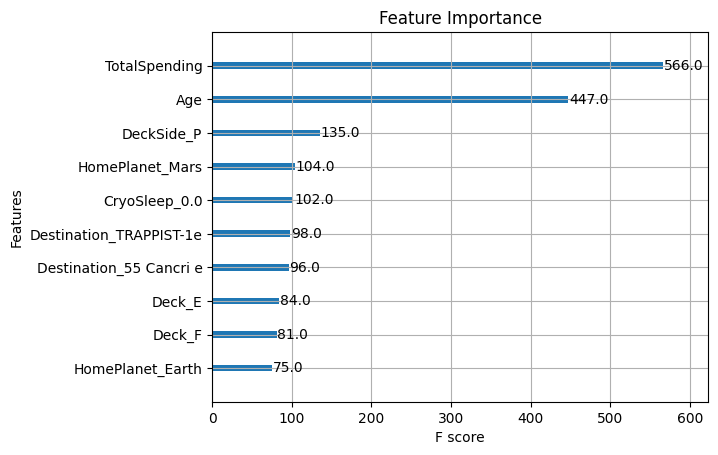

In [ ]:
from xgboost import plot_importance

# 최적의 하이퍼파라미터로 모델 학습
best_xgb_clf = XGBClassifier(n_estimators=int(best['n_estimators']),
                             max_depth=int(best['max_depth']),
                             min_child_weight=int(best['min_child_weight']),
                             learning_rate=best['learning_rate'],
                             colsample_bytree=best['colsample_bytree'],
                             n_jobs=-1)

best_xgb_clf.fit(X_train, y_train)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_clf, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [ ]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Perform cross-validation
cv_results = cross_validate(best_xgb_clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True)

# Display cross-validation results
cv_metrics = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'Precision': cv_results['test_precision'].mean(),
    'Recall': cv_results['test_recall'].mean(),
    'F1 Score': cv_results['test_f1'].mean(),
    'ROC-AUC': cv_results['test_roc_auc'].mean()
}

cv_metrics_df = pd.DataFrame([cv_metrics])
print(cv_metrics_df)

   Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  0.746767   0.796838  0.667143   0.72607  0.805566


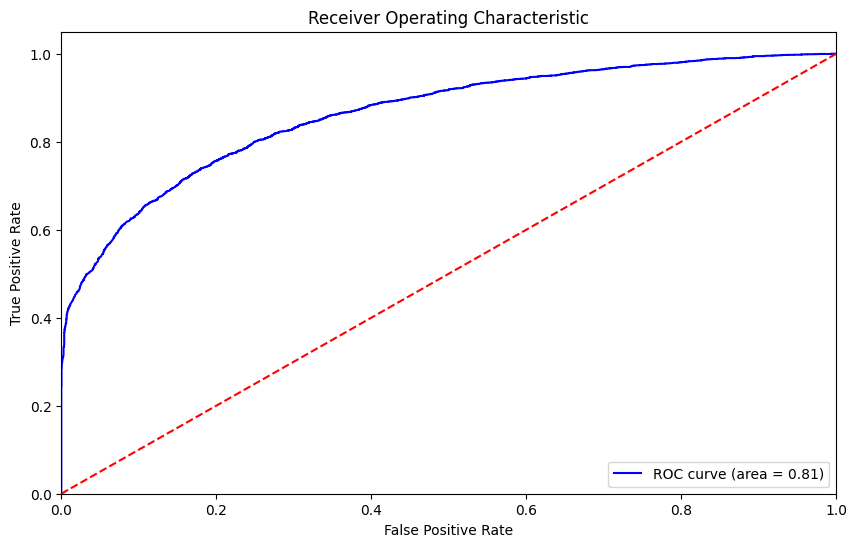

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {cv_metrics["ROC-AUC"]:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### lgbm, RandomForest, GradientBoosting, AdaBoosting

- XGBoost Accuracy가 예상보다 낮아 추가적으로 다른 모델로 예측 및 HyperOpt로 하이퍼 파라미터 튜닝 진행

1. lightgbm

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
train_df = pd.read_csv('/content/train_3.csv')
train_df.drop(columns=['PassengerId'], inplace=True)

X_train = train_df.drop(columns=['Transported'])
y_train = train_df['Transported']

In [ ]:
# Objective 함수
def objective_func(params):
    lgb_clf = lgb.LGBMClassifier(n_estimators=int(params['n_estimators']),
                                 max_depth=int(params['max_depth']),
                                 min_child_weight=int(params['min_child_weight']),
                                 learning_rate=params['learning_rate'],
                                 colsample_bytree=params['colsample_bytree'],
                                 n_jobs=-1)

    accuracy_scores = cross_val_score(lgb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    mean_accuracy = accuracy_scores.mean()

    return {'loss': -1 * mean_accuracy, 'status': STATUS_OK}

# Hyperparameter 탐색 범위 설정
lgb_search_space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
                    'max_depth': hp.quniform('max_depth', 1, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

# Hyperparameter 최적화 진행
trials = Trials()
best = fmin(fn=objective_func,
            space=lgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print('best:', best)

100%|██████████| 50/50 [07:35<00:00,  9.11s/trial, best loss: -0.7438191466201161]
best: {'colsample_bytree': 0.9960460832439993, 'learning_rate': 0.013979195270919512, 'max_depth': 12.0, 'min_child_weight': 1.0, 'n_estimators': 200.0}


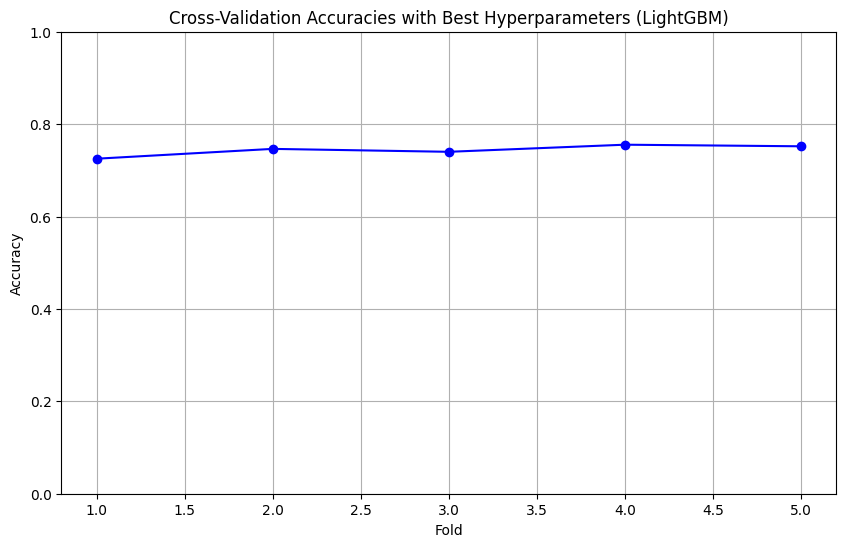

Fold Accuracies:  [0.72512938 0.74640598 0.74008051 0.75546605 0.75201381]
Mean Accuracy:  0.7438191466201161


In [ ]:
# 최적의 하이퍼파라미터로 모델 학습 및 교차 검증
best_lgb_clf = lgb.LGBMClassifier(n_estimators=int(best['n_estimators']),
                                  max_depth=int(best['max_depth']),
                                  min_child_weight=int(best['min_child_weight']),
                                  learning_rate=best['learning_rate'],
                                  colsample_bytree=best['colsample_bytree'],
                                  n_jobs=-1)

accuracy_scores = cross_val_score(best_lgb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
mean_accuracy = accuracy_scores.mean()

# 교차 검증 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracies with Best Hyperparameters (LightGBM)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("Fold Accuracies: ", accuracy_scores)
print("Mean Accuracy: ", mean_accuracy)


2. RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Objective 함수
def objective_func_rf(params):
    rf_clf = RandomForestClassifier(n_estimators=int(params['n_estimators']),
                                    max_depth=int(params['max_depth']),
                                    min_samples_split=int(params['min_samples_split']),
                                    min_samples_leaf=int(params['min_samples_leaf']),
                                    max_features=params['max_features'],
                                    n_jobs=-1)

    accuracy_scores = cross_val_score(rf_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    mean_accuracy = accuracy_scores.mean()

    return {'loss': -1 * mean_accuracy, 'status': STATUS_OK}

# Hyperparameter 탐색 범위 설정
rf_search_space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
                   'max_depth': hp.quniform('max_depth', 1, 20, 1),
                   'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                   'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
                   'max_features': hp.uniform('max_features', 0.1, 1.0)}

# Hyperparameter 최적화 진행
trials_rf = Trials()
best_rf = fmin(fn=objective_func_rf,
               space=rf_search_space,
               algo=tpe.suggest,
               max_evals=50,
               trials=trials_rf)

print('best_rf:', best_rf)

100%|██████████| 50/50 [14:09<00:00, 16.99s/trial, best loss: -0.7496862408524139]
best_rf: {'max_depth': 11.0, 'max_features': 0.4089493948289858, 'min_samples_leaf': 8.0, 'min_samples_split': 2.0, 'n_estimators': 500.0}


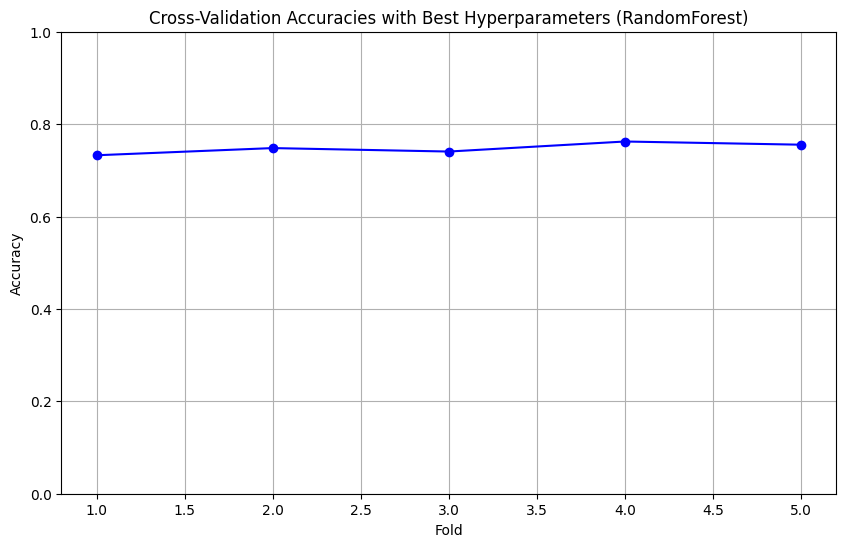

Fold Accuracies:  [0.73260495 0.74813111 0.74065555 0.76237054 0.75546605]
Mean Accuracy:  0.7478456396312577


In [ ]:
# 최적의 하이퍼파라미터로 모델 학습 및 교차 검증
best_rf_clf = RandomForestClassifier(n_estimators=int(best_rf['n_estimators']),
                                     max_depth=int(best_rf['max_depth']),
                                     min_samples_split=int(best_rf['min_samples_split']),
                                     min_samples_leaf=int(best_rf['min_samples_leaf']),
                                     max_features=best_rf['max_features'],
                                     n_jobs=-1)

accuracy_scores = cross_val_score(best_rf_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
mean_accuracy = accuracy_scores.mean()

# 교차 검증 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracies with Best Hyperparameters (RandomForest)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("Fold Accuracies: ", accuracy_scores)
print("Mean Accuracy: ", mean_accuracy)


3. GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Objective 함수
def objective_func_gb(params):
    gb_clf = GradientBoostingClassifier(n_estimators=int(params['n_estimators']),
                                        max_depth=int(params['max_depth']),
                                        min_samples_split=int(params['min_samples_split']),
                                        min_samples_leaf=int(params['min_samples_leaf']),
                                        learning_rate=params['learning_rate'],
                                        subsample=params['subsample'])

    accuracy_scores = cross_val_score(gb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    mean_accuracy = accuracy_scores.mean()

    return {'loss': -1 * mean_accuracy, 'status': STATUS_OK}

# Hyperparameter 탐색 범위 설정
gb_search_space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
                   'max_depth': hp.quniform('max_depth', 1, 20, 1),
                   'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                   'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
                   'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
                   'subsample': hp.uniform('subsample', 0.5, 1.0)}

# Hyperparameter 최적화 진행
trials_gb = Trials()
best_gb = fmin(fn=objective_func_gb,
               space=gb_search_space,
               algo=tpe.suggest,
               max_evals=50,
               trials=trials_gb)

print('best_gb:', best_gb)


100%|██████████| 50/50 [29:35<00:00, 35.51s/trial, best loss: -0.7411735511924038]
best_gb: {'learning_rate': 0.37481882099679387, 'max_depth': 2.0, 'min_samples_leaf': 3.0, 'min_samples_split': 8.0, 'n_estimators': 100.0, 'subsample': 0.9635024882581726}


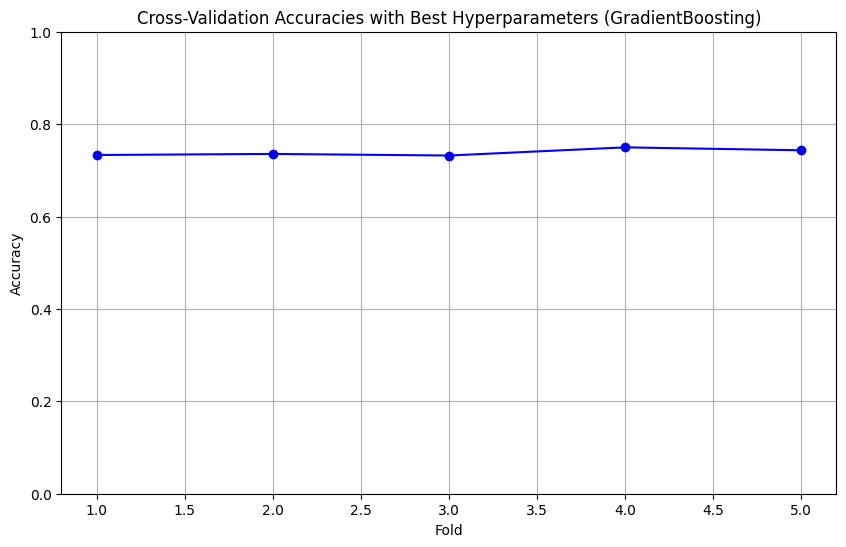

Fold Accuracies:  [0.73317999 0.73548016 0.7320299  0.74971231 0.7433832 ]
Mean Accuracy:  0.7387571127673471


In [ ]:
# 최적의 하이퍼파라미터로 모델 학습 및 교차 검증
best_gb_clf = GradientBoostingClassifier(n_estimators=int(best_gb['n_estimators']),
                                         max_depth=int(best_gb['max_depth']),
                                         min_samples_split=int(best_gb['min_samples_split']),
                                         min_samples_leaf=int(best_gb['min_samples_leaf']),
                                         learning_rate=best_gb['learning_rate'],
                                         subsample=best_gb['subsample'])

accuracy_scores = cross_val_score(best_gb_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
mean_accuracy = accuracy_scores.mean()

# 교차 검증 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracies with Best Hyperparameters (GradientBoosting)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("Fold Accuracies: ", accuracy_scores)
print("Mean Accuracy: ", mean_accuracy)

4. AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Objective 함수
def objective_func_ab(params):
    ab_clf = AdaBoostClassifier(n_estimators=int(params['n_estimators']),
                                learning_rate=params['learning_rate'])

    accuracy_scores = cross_val_score(ab_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    mean_accuracy = accuracy_scores.mean()

    return {'loss': -1 * mean_accuracy, 'status': STATUS_OK}

# Hyperparameter 탐색 범위 설정
ab_search_space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
                   'learning_rate': hp.uniform('learning_rate', 0.01, 1.0)}

# Hyperparameter 최적화 진행
trials_ab = Trials()
best_ab = fmin(fn=objective_func_ab,
               space=ab_search_space,
               algo=tpe.suggest,
               max_evals=50,
               trials=trials_ab)

print('best_ab:', best_ab)

100%|██████████| 50/50 [09:30<00:00, 11.41s/trial, best loss: -0.7384120868904063]
best_ab: {'learning_rate': 0.09700938653303726, 'n_estimators': 200.0}


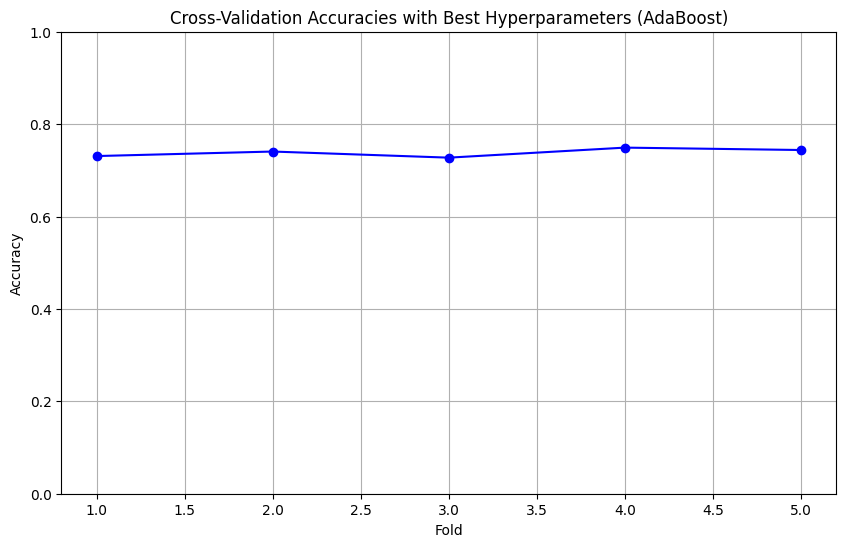

Fold Accuracies:  [0.73087982 0.74065555 0.72742956 0.74913694 0.74395857]
Mean Accuracy:  0.7384120868904063


In [ ]:
# 최적의 하이퍼파라미터로 모델 학습 및 교차 검증
best_ab_clf = AdaBoostClassifier(n_estimators=int(best_ab['n_estimators']),
                                 learning_rate=best_ab['learning_rate'])

accuracy_scores = cross_val_score(best_ab_clf, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
mean_accuracy = accuracy_scores.mean()

# 교차 검증 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracies with Best Hyperparameters (AdaBoost)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("Fold Accuracies: ", accuracy_scores)
print("Mean Accuracy: ", mean_accuracy)


5. 모델별 정확도

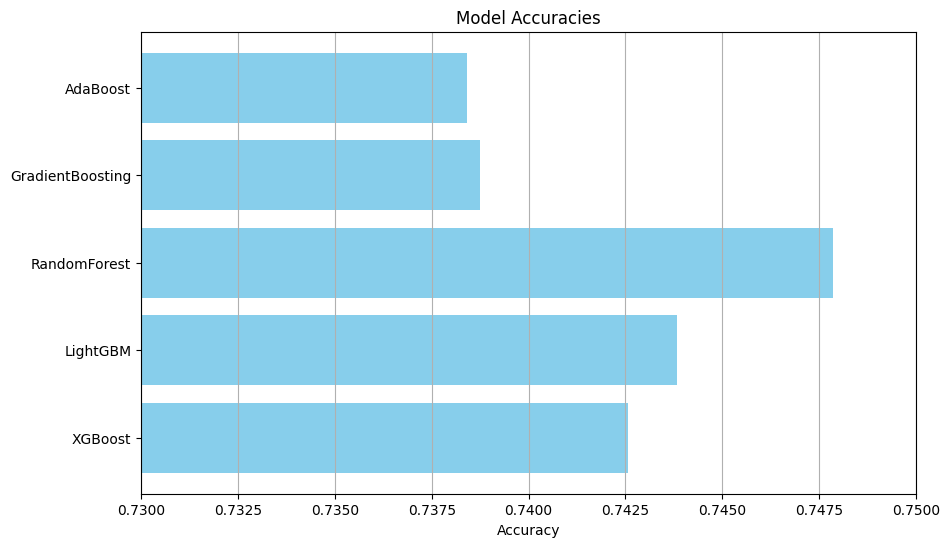

In [ ]:
import matplotlib.pyplot as plt

models = ['XGBoost', 'LightGBM', 'RandomForest', 'GradientBoosting', 'AdaBoost']
accuracies = [0.7425533238353061, 0.7438191466201161, 0.7478456396312577, 0.7387571127673471, 0.7384120868904063]
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0.73, 0.75)
plt.grid(axis='x')
plt.show()

## 5. 모델링 및 성능 평가 결론

- 다른 모델들
  - XGBoost와 Accuracy가 비슷하거나 낮았음
- XGBoost GridSerchCV vs. HyperOpt
  - GridSearchCV는 대부분의 지표에서 HyperOpt보다 약간 더 높은 성능을 보였음
  - 정확도(Accuracy), 정밀도(Precision), F1 스코어(F1 Score), 그리고 ROC-AUC 점수에서 GridSearchCV가 더 좋은 성능을 보였음
  - 재현율(Recall)은 HyperOpt가 약간 더 높았음
- 최종적으로 XGBoost(GridSearchCV)로 Kaggle에 submission

## 6. KaggleSubmission

- XGBoost(GridSerchCV)로 최종 예측 진행 및 submission

In [ ]:
# Extract features from test data
X_real_test = real_test.drop(columns=['PassengerId', 'Transported'])

In [ ]:
X_real_test

,Age,CryoSleep_0.0,CryoSleep_1.0,VIP_0.0,VIP_1.0,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,DeckSide_P,DeckSide_S,TotalSpending
0,0.341772,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
1,0.240506,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.203344
2,0.392405,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
3,0.481013,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.401097
4,0.253165,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.178390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.430380,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
4273,0.531646,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.334841
4274,0.341772,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
4275,0.341772,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.277336


In [ ]:
# Predict on the test data
y_pred = xgb_model.predict(X_real_test)

In [ ]:
# Convert predictions to 'True' and 'False'
y_pred = np.where(y_pred == 1, True, False)

In [ ]:
# Prepare the submission dataframe
submission = pd.DataFrame({
    'PassengerId': real_test['PassengerId'],
    'Transported': y_pred
})

In [ ]:
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)